In [15]:
import pyvista, ufl

import numpy as np

from mpi4py import MPI
from dolfinx import default_scalar_type, fem, mesh, plot
from dolfinx.fem import functionspace
from dolfinx.fem.petsc import LinearProblem

In [16]:
width = 2e-3
height = 3e-3
corner1 = np.array([0.0, 0.0])
corner2 = np.array([width, height])

# Number of elements (divisions) in x and y directions
nx, ny = 20, 30

# Create the rectangular mesh
domain = mesh.create_rectangle(MPI.COMM_WORLD, [corner1, corner2], [nx, ny], mesh.CellType.quadrilateral)

d_dim = domain.topology.dim
b_dim = d_dim - 1

In [17]:
pyvista.start_xvfb()
topology, cell_types, geometry = plot.vtk_mesh(domain, d_dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

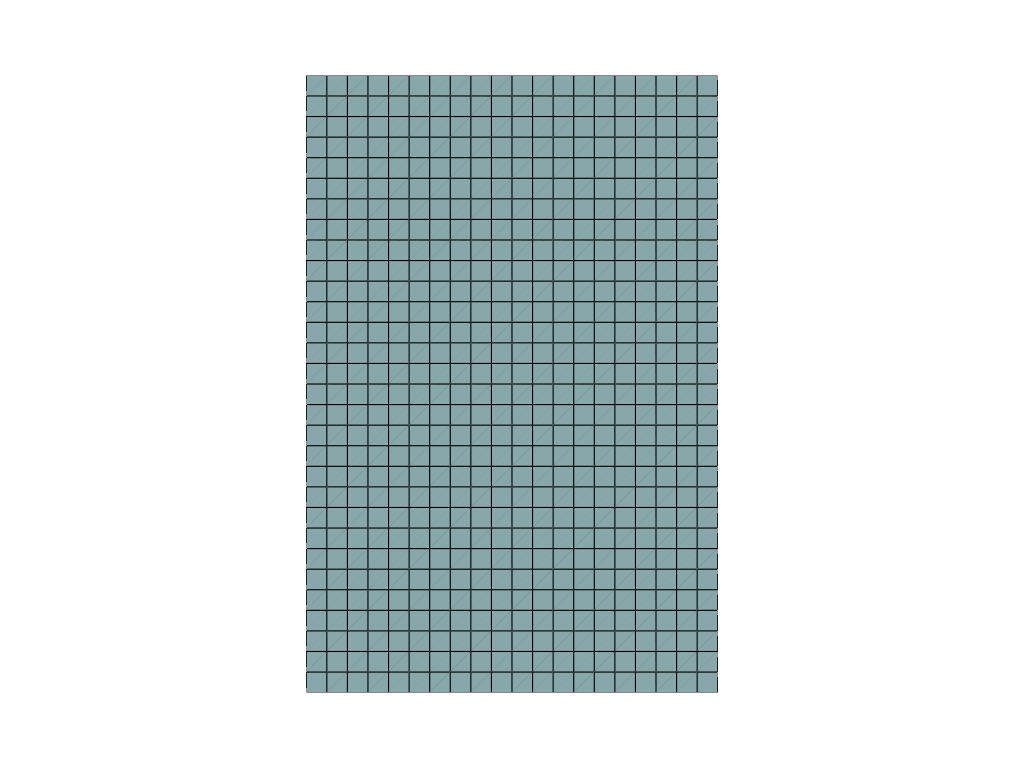

In [18]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

In [19]:
V = functionspace(domain, ("Lagrange", 3))

In [20]:
# Create facet to cell connectivity required to determine boundary facets
domain.topology.create_connectivity(b_dim, d_dim)

In [21]:
def boundary_x0(x):
    return np.isclose(x[0], 0.0)

def boundary_x2(x):
    return np.isclose(x[0], width)

def boundary_y3(x):
    return np.isclose(x[1], height)

def boundary_y0(x):
    return np.isclose(x[1], 0.0)

boundary_dofs_x0 = fem.locate_dofs_geometrical(V, boundary_x0)
boundary_dofs_x2 = fem.locate_dofs_geometrical(V, boundary_x2)
boundary_dofs_y0 = fem.locate_dofs_geometrical(V, boundary_y0)
boundary_dofs_y3 = fem.locate_dofs_geometrical(V, boundary_y3)

bc_x0 = fem.dirichletbc(fem.Constant(domain, 0.0), boundary_dofs_x0, V)
bc_x2 = fem.dirichletbc(fem.Constant(domain, 10.0), boundary_dofs_x2, V)
bc_y3 = fem.dirichletbc(fem.Constant(domain, 20.0), boundary_dofs_y3, V)

# Combine the Dirichlet boundary conditions into a list
bcs = [bc_x0, bc_x2, bc_y3]

In [22]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

In [23]:
f = fem.Constant(domain, default_scalar_type(0))

In [52]:
k = ufl.as_tensor([[900, -10], [-10, 100]])
flux_value = 10000000

a = ufl.dot(ufl.dot(k, ufl.grad(u)), ufl.grad(v)) * ufl.dx

L = f * v * ufl.dx + flux_value * v * ufl.ds

In [53]:
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [54]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)

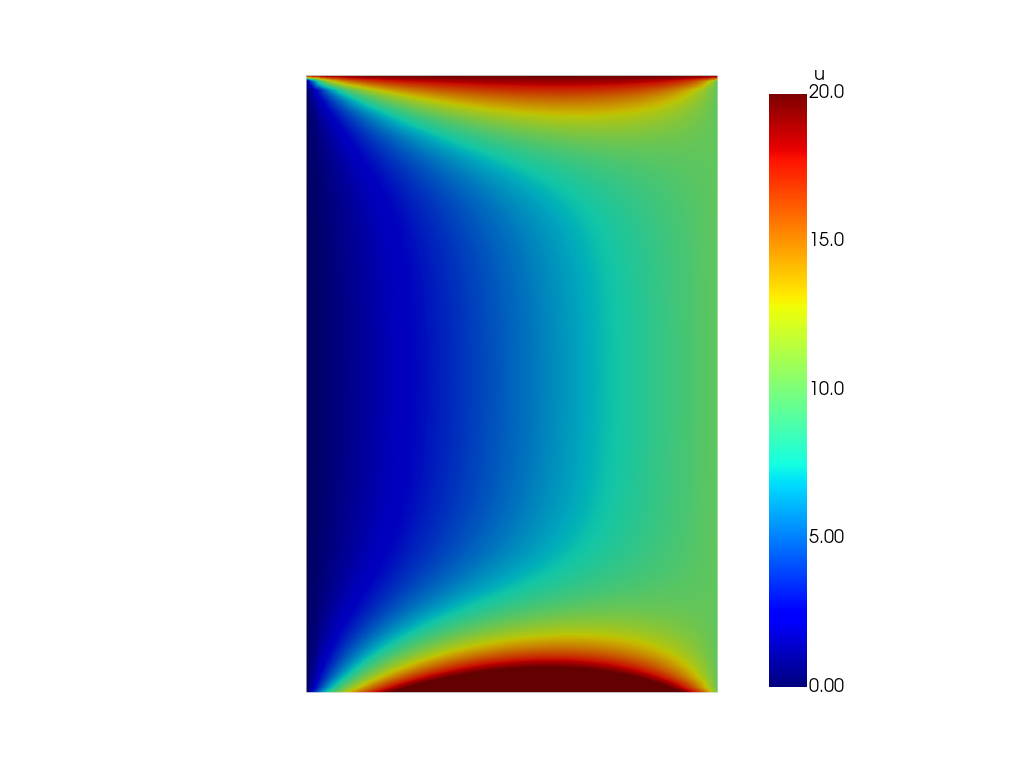

In [55]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()

scalar_bar_args = {"title": "u", "vertical": True, "position_x": 0.75, "position_y": 0.1, "width": 0.1, "height": 0.8}
u_plotter.add_mesh(u_grid, show_edges=False, cmap="jet", clim=[0, 20], scalar_bar_args=scalar_bar_args)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()